# Analyzing Wordle Simulations

## Goal to create optimal wordle guessing strategy
**Key steps**
1. Build solver that can score all potential guesses based on a variety of features
2. Create simulation capability to run many games with psuedo random guessing scoring each guess by the variety of features
3. Use results from simulation to understand impact of variety of features on key game goals...
    1. Likelihood of a given word to be the correct guess
    2. Estimated value of a given word in reducing guesses remaining

**Key assumptions**
* I will build everything with a self-made version of wordle that accepts any alphanumeric word of a given length. This means it will be _worse_ at purely helping with the game of wordle (as I will train on a wider corpus than the actual wordle corpus)
* My wordleGame picks one of the top 10,000 most common English words for a given length using `get_frequency_dict('en', wordlist='best')`. Guesses can come from any of the words in that corpus
* I choose to set this up to play on hard mode. This means that each subsequent guess _must_ use information obtained in prior guesses. https://www.gamerevolution.com/guides/699992-wordle-hard-mode-how-to-turn-on-differences-harder-expert

In [2]:
# Importing relevant libraries
import pandas
import json
import matplotlib
from matplotlib import pyplot
import seaborn as sns
import random
from wordleSimulator import run_simulation
import numpy as np

#### Step 1: Build wordleSolver

You can find the wordleSolver I created elsewhere in this directory. The key information on the solver are the features that I ended up scoring against.

**Data we track**
* Game relevant data: information we have at this point in the game
    1. `turn_number`: which turn we are on in the game
    2. `words_possible`: how many potential words remain in our corpus
    3. `letter_in`: set of letters we confirmed **are** in the word
    4. `letter_out`: set of letters we confirmed are **not** in the word
    5. `pos_yes`: array of sets for letters we confirmed **are** in a given position (e.g green boxes)
    6. `pos_no`: array of sets for letters we confirmed are **not** a given position (e.g grey or yellow boxes)


* Guess: information we have for each potential guess
    1. `freq`: the word_frequency of a given word from the word_frequency corpus
    2. `letter_scores_by_word`: after each guess we take all the remaining possible words and count how many of each letter is in the remaining potential word list. We then give each potential guess a score if it includes the most common remaining letters
    3. `letter_scores_by_freq`: same as above, but weighting based on frequency of remaining words (e.g `their` will count more than `gyong` because it is much more frequently used
    4. `letter_scores_pos_perc`: similar to letter scores, but by frequency. If 50% of remaining words had a letter a second words with letter a second will get higher scores
    5. `letter_scores_pos_freq`: same as above, but weighted by frequency of remaining words

#### Step 2: Build simulation

You can find the wordleSimulation I created elsewhere in this directory. Most importantly in this section I will show the code I used to create the sample data I used to train various models.

**Please note: simulations will take a long time to ready, depending on your machine! It's worth testing how long it takes and deciding how big a simulation you want to run.**

In [ ]:
# Run 5,000 simulations. These simulations will be based on 100 starting words
# Each starting word will have 50 different wordleSolver's guess until we get the right word
# I did this in order to investigate differences based on randomness and attempt to understand
# What kind of strategies led to the slowest and fastest guesses for the same word

for i in range(100):
    run_simulation(n_letters=5, sims=50, same_word=True, random_guess = True, \
                   game_log='./simulations/gamelog_same_final_word.csv', \
                   turn_log='./simulations/turnlog_same_final_word.csv', start_word=None)


In [ ]:
# Run 1,000 simulations choosing a random starter word AND random guessing the whole way
for i in range(1000):
    run_simulation(n_letters=5, sims=1, same_word=False, random_guess = True, \
                   game_log='./simulations/gamelog_random_words_only.csv', \
                   turn_log='./simulations/turnlog_random_words_only.csv', start_word=None)
    

In [ ]:
# Run 1,000 simulations with a simple model that equally weights the four features we have `letter_score_by_word`,
# `letter_scores_by_freq`, `letter_scores_pos_perc`, `letter_scores_pos_freq`
# Run on the words that this model projects are the best starter words
top_model_words_to_test = ['their', 'about', 'other', 'after', 'years', 'great', 'those', 'raise', 'there', 'rates',
            'later', 'arise', 'aires', 'aries', 'arose', 'tears', 'stare', 'artie', 'irate', 'taser', 'aster', 'least',
            'first', 'oates', 'share', 'heart', 'arnie', 'reina', 'raine', 'einar', 'irena', 'earns', 'snare', 'nears',
            'arent', 'siena', 'anise', 'eason', 'earth', 'laser', 'learn', 'eatin', 'ariel', 'eaton', 'earls', 'reals', 'arles']

for w in top_model_words_to_test:
    print(f"Working on: {w}...")
    run_simulation(n_letters=5, sims=20, game_log='./simulations/gamelog_model.csv', turn_log='./simulations/turnlog_model.csv', start_word=w)

#### Step 3: Use results from simulation to understand various features on solving wordle

**3a. Starting with exploring game level data**

In [4]:
df = pandas.read_csv('./simulations/gamelog_same_final_word.csv')

In [7]:
# Number of games in this dataset
len(df)

5001

<AxesSubplot:>

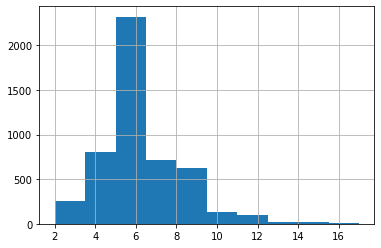

In [12]:
df['turns'].hist()

In [14]:
df.agg({'turns': ['mean', 'count', 'median', 'std']})

,turns
mean,5.988802
count,5001.000000
median,6.000000
std,1.972581


Overall - random guessing is surprisingly effective, at least when the guesses are restricted to possible words. Let's compare that to a very basic non-weighted modeled approach

In [21]:
df_base_rank = pandas.read_csv('./simulations/gamelog_model.csv')

In [22]:
# Number of games in this dataset
len(df_base_rank)

4701

<AxesSubplot:>

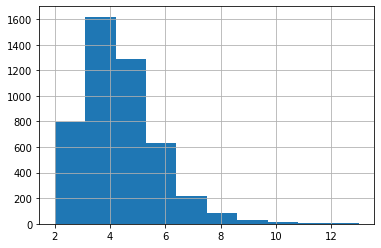

In [23]:
df_base_rank['turns'].hist()

In [24]:
df_base_rank.agg({'turns': ['mean', 'count', 'median', 'std']})

,turns
mean,4.641991
count,4701.000000
median,4.000000
std,1.324441


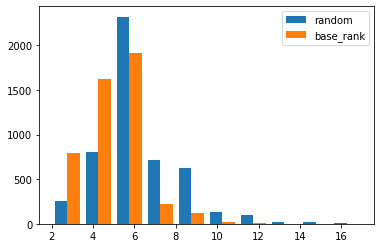

In [25]:
pyplot.hist([df['turns'],df_base_rank['turns']], label=['random', 'base_rank'])
pyplot.legend(loc='upper right')
pyplot.show()

Picking the top word by a simple ranking does a lot better than random! (phew). Let's see if we can improve on this further with modeling

**3b. Jumping into some turn level data**

In [129]:
df_turn = pandas.read_csv('./simulations/turnlog_same_final_word.csv')

In [130]:
len(df_turn)

29957

In [131]:
# View a full random game
df_turn.head(7)

,game_id,turn_number,guess,words_possible,letters_in,letters_out,pos_yes,pos_no,freq,letter_score_by_word,letter_score_by_freq,distinct_letters,letter_pos_score_by_word,letter_pos_score_by_freq,model_params,model_rank,response
0,03bc8c08c1875,1,vytas,38809,[],[],"[[], [], [], [], []]","[[], [], [], [], []]",0.000007,0.659429,0.625558,1.0,0.507093,0.353622,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.145709,____+
1,03bc8c08c1875,2,scops,2129,['s'],"['y', 'v', 'a', 't']","[[], [], [], [], ['s']]","[[], [], [], [], []]",0.000120,0.491831,0.480528,0.6,0.238921,0.277994,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",2.089394,-___+
2,03bc8c08c1875,3,neris,832,['s'],"['y', 'a', 'p', 'o', 'c', 'v', 't']","[[], [], [], [], ['s']]","[['s'], [], [], [], []]",0.000135,0.983382,0.933885,1.0,0.726705,0.528023,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",4.172129,_+__+
3,03bc8c08c1875,4,hemes,96,"['s', 'e']","['y', 'n', 'a', 'i', 'p', 'r', 'o', 'c', 'v', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], [], []]",0.000074,0.455556,0.462639,0.6,0.401255,0.058549,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",1.978073,_+_-+
4,03bc8c08c1875,5,feels,44,"['s', 'e']","['y', 'n', 'm', 'a', 'i', 'p', 'r', 'o', 'c', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], ['e'], []]",0.512861,0.627907,0.735557,0.6,0.406321,0.578721,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.461367,_+--+
5,03bc8c08c1875,6,belus,6,"['s', 'e', 'l']","['y', 'n', 'm', 'a', 'i', 'p', 'f', 'r', 'o', ...","[[], ['e'], [], [], ['s']]","[['s'], [], ['e'], ['e', 'l'], []]",0.024547,0.857143,0.805863,1.0,1.000000,0.518187,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",4.205740,_++_+
6,03bc8c08c1875,7,welds,2,"['s', 'e', 'l']","['y', 'n', 'm', 'a', 'u', 'i', 'p', 'f', 'r', ...","[[], ['e'], ['l'], [], ['s']]","[['s'], [], ['e'], ['e', 'l'], []]",1.000000,1.000000,1.000000,1.0,1.000000,1.000000,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",6.000000,+++++


In [132]:
# Seeing what percent each guess reduced number of possible words
df_turn['word_ratio'] = (df_turn['words_possible'].shift(-1) / df_turn['words_possible']).apply(lambda l: l if l < 1 else None)


In [133]:
df_turn_not_last = df_turn.copy(deep=True)

In [134]:
df_turn_not_last.dropna()

,game_id,turn_number,guess,words_possible,letters_in,letters_out,pos_yes,pos_no,freq,letter_score_by_word,letter_score_by_freq,distinct_letters,letter_pos_score_by_word,letter_pos_score_by_freq,model_params,model_rank,response,word_ratio
0,03bc8c08c1875,1,vytas,38809,[],[],"[[], [], [], [], []]","[[], [], [], [], []]",0.000007,0.659429,0.625558,1.0,0.507093,0.353622,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.145709,____+,0.054858
1,03bc8c08c1875,2,scops,2129,['s'],"['y', 'v', 'a', 't']","[[], [], [], [], ['s']]","[[], [], [], [], []]",0.000120,0.491831,0.480528,0.6,0.238921,0.277994,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",2.089394,-___+,0.390794
2,03bc8c08c1875,3,neris,832,['s'],"['y', 'a', 'p', 'o', 'c', 'v', 't']","[[], [], [], [], ['s']]","[['s'], [], [], [], []]",0.000135,0.983382,0.933885,1.0,0.726705,0.528023,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",4.172129,_+__+,0.115385
3,03bc8c08c1875,4,hemes,96,"['s', 'e']","['y', 'n', 'a', 'i', 'p', 'r', 'o', 'c', 'v', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], [], []]",0.000074,0.455556,0.462639,0.6,0.401255,0.058549,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",1.978073,_+_-+,0.458333
4,03bc8c08c1875,5,feels,44,"['s', 'e']","['y', 'n', 'm', 'a', 'i', 'p', 'r', 'o', 'c', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], ['e'], []]",0.512861,0.627907,0.735557,0.6,0.406321,0.578721,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.461367,_+--+,0.136364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29950,48fcc98e79e0ea,2,tautz,9063,[],"['g', 'o', 's', 'n', 'h']","[[], [], [], [], []]","[[], [], [], [], []]",0.000013,0.513379,0.429612,0.6,0.560359,0.413350,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",2.516711,-+_-_,0.022730
29951,48fcc98e79e0ea,3,rater,206,"['t', 'a']","['g', 'o', 's', 'u', 'n', 'h', 'z']","[[], ['a'], [], [], []]","[['t'], [], [], ['t'], []]",0.000603,0.773196,0.861137,0.6,0.903370,0.816949,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.955254,-+-_-,0.048544
29953,49adf1dfb9b020,1,vexin,38809,[],[],"[[], [], [], [], []]","[[], [], [], [], []]",0.000005,0.592063,0.572420,1.0,0.502701,0.300148,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",2.967338,_____,0.254194
29954,49adf1dfb9b020,2,kobra,9865,[],"['x', 'n', 'v', 'i', 'e']","[[], [], [], [], []]","[[], [], [], [], []]",0.000030,0.837993,0.765185,1.0,0.640504,0.456875,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.700587,+__--,0.006589


In [135]:
df_turn_not_last.groupby('turn_number').agg({'words_possible': ['mean', 'count', 'median', 'std'], 'word_ratio': ['mean', 'count', 'median', 'std']})

words_possible                             word_ratio        \
                      mean count   median          std       mean count   
turn_number                                                               
1             38809.000000  5002  38809.0     0.000000   0.096351  5002   
2              3739.268293  5002   2095.5  4334.447208   0.135539  4982   
3               354.706744  4982    130.0   653.399181   0.224900  4741   
4                46.036279  4741     16.0    93.954489   0.369086  3938   
5                11.886745  3938      5.0    20.460283   0.499651  2671   
6                 6.174092  2671      4.0     8.741524   0.585036  1616   
7                 4.302599  1616      3.0     4.434527   0.646083   903   
8                 3.750831   903      3.0     2.863668   0.688619   490   
9                 3.600000   490      3.0     2.316298   0.714587   279   
10                3.544803   279      3.0     2.219266   0.711252   149   
11                3.436242   149      3.0     2.135043   0.730470    79   
12                3.468354    79      3.0     1.781928   0.722886    49   
13                3.183673    49      3.0     1.495458   0.694444    30   
14                2.666667    30      3.0     1.184187   0.662500    16   
15                2.250000    16      2.0     1.000000   0.629630     9   
16                1.888889     9      2.0     0.781736   0.500000     1   
17                1.000000     1      1.0          NaN        NaN     0   

                                 
               median       std  
turn_number                      
1            0.053995  0.111687  
2            0.083072  0.148483  
3            0.142857  0.216708  
4            0.333333  0.265864  
5            0.500000  0.262212  
6            0.666667  0.238437  
7            0.666667  0.211600  
8            0.750000  0.184232  
9            0.750000  0.144397  
10           0.750000  0.142831  
11           0.750000  0.125960  
12           0.750000  0.116052  
13           0.750000  0.111015  
14           0.666667  0.107755  
15           0.666667  0.103003  
16           0.500000       NaN  
17                NaN       NaN

Even in random guessing 1064 games are done after 4 turns, and of the remaining we are down to a median of 5 words possible at that point. 

#### 3c. Begin to model likelihood of correct guess

In [136]:
# Add pandas column for target of correct guess
df_turn['last_guess'] = df_turn['response'] == '+++++'

In [137]:
# Convert game info we have into quantifiable features that can be used in a model
df_turn['letter_in_count'] = (df_turn['letters_in'].apply(len)/5).apply(np.floor)
df_turn['letter_out_count'] = (df_turn['letters_out'].apply(len)/5).apply(np.floor)
df_turn['letter_in_pos'] = (df_turn['pos_yes'].str.count('\'')/2).apply(np.floor)
df_turn['letter_out_pos'] = (df_turn['pos_no'].str.count('\'')/2).apply(np.floor)

In [138]:
df_turn.head()

,game_id,turn_number,guess,words_possible,letters_in,letters_out,pos_yes,pos_no,freq,letter_score_by_word,...,letter_pos_score_by_freq,model_params,model_rank,response,word_ratio,last_guess,letter_in_count,letter_out_count,letter_in_pos,letter_out_pos
0,03bc8c08c1875,1,vytas,38809,[],[],"[[], [], [], [], []]","[[], [], [], [], []]",0.000007,0.659429,...,0.353622,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.145709,____+,0.054858,False,0.0,0.0,0.0,0.0
1,03bc8c08c1875,2,scops,2129,['s'],"['y', 'v', 'a', 't']","[[], [], [], [], ['s']]","[[], [], [], [], []]",0.000120,0.491831,...,0.277994,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",2.089394,-___+,0.390794,False,1.0,4.0,1.0,0.0
2,03bc8c08c1875,3,neris,832,['s'],"['y', 'a', 'p', 'o', 'c', 'v', 't']","[[], [], [], [], ['s']]","[['s'], [], [], [], []]",0.000135,0.983382,...,0.528023,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",4.172129,_+__+,0.115385,False,1.0,7.0,1.0,1.0
3,03bc8c08c1875,4,hemes,96,"['s', 'e']","['y', 'n', 'a', 'i', 'p', 'r', 'o', 'c', 'v', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], [], []]",0.000074,0.455556,...,0.058549,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",1.978073,_+_-+,0.458333,False,2.0,10.0,2.0,1.0
4,03bc8c08c1875,5,feels,44,"['s', 'e']","['y', 'n', 'm', 'a', 'i', 'p', 'r', 'o', 'c', ...","[[], ['e'], [], [], ['s']]","[['s'], [], [], ['e'], []]",0.512861,0.627907,...,0.578721,"{'freq': 1, 'letter_score_by_word': 1, 'letter...",3.461367,_+--+,0.136364,False,2.0,12.0,2.0,2.0


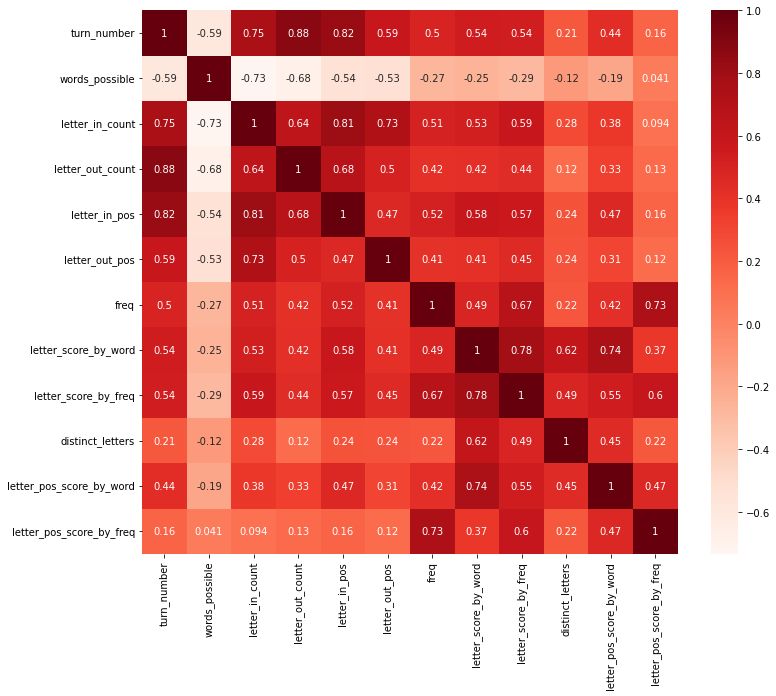

In [139]:
# Let's see how correlated all these values are
pyplot.figure(figsize=(12,10))
cor = df_turn[['turn_number', 'words_possible', 'letter_in_count', 'letter_out_count', 'letter_in_pos', \
               'letter_out_pos', 'freq', 'letter_score_by_word', 'letter_score_by_freq', 'distinct_letters',\
               'letter_pos_score_by_word', 'letter_pos_score_by_freq'\
              ]].corr()
sns.heatmap(cor, annot=True, cmap=pyplot.cm.Reds)
pyplot.show()

In [140]:
features = df_turn[['turn_number', 'words_possible', 'letter_in_count', 'letter_out_count', 'letter_in_pos', \
               'letter_out_pos', 'freq', 'letter_score_by_word', 'letter_score_by_freq', 'distinct_letters',\
               'letter_pos_score_by_word', 'letter_pos_score_by_freq'\
              ]]
target = df_turn['last_guess']

In [141]:
features.fillna(0,inplace=True)

/Users/jonkatzur/opt/miniconda3/envs/udacity/lib/python3.8/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [142]:
from sklearn.model_selection import train_test_split
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.5, random_state=42)


In [160]:
from sklearn import linear_model, preprocessing
reg = linear_model.LogisticRegression()

min_max_scaler = preprocessing.MinMaxScaler()
feature_train_minmax = min_max_scaler.fit_transform(feature_train)

reg.fit (feature_train_minmax, target_train)
print(f"Coefficient: {(reg.coef_)}")

Coefficient: [[-1.23486764 -1.95882903  1.48898911  1.71263277  0.17237979  0.52855907
   4.24626739  3.46819915  1.31959247  0.24439019  0.42620307 -0.52093686]]


In [162]:
print(f"Intecept: {reg.intercept_}")
feature_test_minmax = min_max_scaler.fit_transform(feature_test)
print(f"R^2 in training of: {reg.score(feature_train_minmax,target_train)}")
print(f"R^2 in test of: {reg.score(feature_test_minmax,target_test)}")

Intecept: [-9.27981986]
R^2 in training of: 0.939578047803445
R^2 in test of: 0.9353094332064891


Model seems to do a good job of predicting if this guess is going to be right! Let's look at some scores in our data to see if it looks right. 

In [166]:
print(f"{reg.predict_proba(feature_test_minmax)[12][1]:.9f}")

0.000993024


Next up is to spend time seeing if this model is actually good. Then working on the word possible reduction!